# Pruebas para la igualdad de dos distribuciones (localización)

### Modelos no paramétricos y de regresión
##### Por: Jorge Iván Reyes Hernández

In [1]:
from abc import ABC

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom
from scipy.stats import norm, chi2

In [2]:
class EqualityTest(ABC):
    """ Clase para implementar la prueba de igualdad de dos distribuciones (localización). """
    
    def __init__(self, x, y):
        """ Constructor de la clase.
        
        :param x: Mediciones de la primera distribución.
        :param y: Mediciones de la segunda distribución.
        """
        self._x = x
        self._y = y
        self._sample = None
        self._indices = {"X": [], "Y": []}
        self._n_1: int = x.size
        self._n_2: int = y.size
        self._n: int = self._n_1 + self._n_2
        self._significance_level: float = 0.0
        self.__merge_data()
        
    def get_x(self):
        """ Regresa los datos de la primera muestra.
        
        :return: Mediciones de la primera distribución.
        """
        return self._x
    
    def get_y(self):
        """ Regresa los datos de la segunda muestra.
        
        :return: Mediciones de la segunda distribución.
        """
        return self._y
    
    def get_sample(self):
        """ Regresa los datos en una única muestra dicotomizada.
        
        :return: Muestra mezclada.
        """
        return self._sample
    
    def get_indices(self):
        return self._indices
    
    def get_n_1(self):
        return self._n_1
    
    def get_n_2(self):
        return self._n_2
    
    def __merge_data(self):
        """ Método para dicotomizar los datos.
        
            Se ignoran los empates.
            Se guardan los índices de las X's y de las Y's.
        """
        
        x = np.sort(self._x, kind="mergesort")
        y = np.sort(self._y, kind="mergesort")
        
        merged = []
        
        i, j = 0, 0
        n_1, n_2 = 0, 0
        idx = 0
        
        while (i < self._n_1 and j < self._n_2):
            if x[i] < y[j]:
                merged.append("X")
                self._indices["X"].append(idx)
                n_1 += 1
                i += 1
                idx += 1
            elif x[i] > y[j]:
                merged.append("Y")
                self._indices["Y"].append(idx)
                n_2 += 1
                j += 1
                idx += 1
            else:
                i += 1
                j += 1
        
        while i < self._n_1:
            merged.append("X")
            self._indices["X"].append(idx)
            n_1 += 1
            i += 1
            idx += 1
        
        while j < self._n_2:
            merged.append("Y")
            self._indices["Y"].append(idx)
            n_2 += 1
            j += 1
            idx += 1
        
        self._sample = np.array(merged)
        self._n_1 = n_1
        self._n_2 = n_2
        self._n = self._n_1 + self._n_2


### Prueba basada en rachas (Wald-Wolfowitz Runs test)

In [3]:
class RunsEqualityTest(EqualityTest):
    """ Clase para implementar la prueba de Wald-Wolfowitz (basada en rachas)."""
    
    def __init__(self, x, y):
        """ Constructor de la clase.
        
        :param x: Mediciones de la primera distribución.
        :param y: Mediciones de la segunda distribución.
        """
        super().__init__(x, y)
        self.__r = 1
        self.__compute_runs()
        
    def get_runs(self):
        """ Regresa la cantidad de rachas en la muestra."""
        return self.__r
        
    def __compute_runs(self):
        """ Calcula la cantidad de rachas observadas."""
        cur = self._sample[0]
        for i in range(1, self._sample.size):
            if cur != self._sample[i]:
                self.__r += 1
            cur = self._sample[i]
    
    def __pmf_even(self, r):
        """ Función de probabilidad de la estadística de prueba cuando r es par.
        
        :param r: Valor que toma R.
        :return: La probabilidad de que R=r
        """
        num = 2 * binom(self._n_1 - 1, r / 2 - 1) * binom(self._n_2 - 1, r / 2 - 1)
        den = binom(self._n, self._n_1)
        return num / den
    
    def __pmf_odd(self, r):
        """ Función de probabilidad de la estadística de prueba cuando r es impar.
        
        :param r: Valor que toma R.
        :return: La probabilidad de que R=r
        """
        num = binom(self._n_1 - 1, (r - 1) / 2) * binom(self._n_2 - 1, (r - 3) / 2)
        num += binom(self._n_1 - 1, (r - 3) / 2) * binom(self._n_2 - 1, (r - 1) / 2)
        den = binom(self._n, self._n_1)
        return num / den
        
    def __test_statistic_exact(self, alpha):
        """ Calcula las constantes (cuántiles) de la pmf de R tales que la proba acumulada
        sea menor que el nivel de significancia para la prueba de dos colas.
        
        :param alpha: Nivel de significancia deseado.
        :return: La constante que define la región crítica.
        """
        prob = 0.0
        k = 1
        while prob <= alpha and (k <= self._n):
            self._significance_level = prob
            k += 1
            p = self.__pmf_even(k) if (k % 2 == 0) else self.__pmf_odd(k)
            prob += p
        k -= 1
        return k
    
    def __test_statistic_asymptotic(self):
        """ Calcula la estadística de prueba asintótica.
        
        :return: El valor que toma la estadística de pruba.
        """
        num = self.__r + 0.5 - 1 - (2 * self._n_1 * self._n_2 / self._n)
        den = 2 * self._n_1 * self._n_2 * (2 * self._n_1 * self._n_2 - self._n)
        den /= (self._n ** 2) * (self._n - 1)
        den = np.sqrt(den)
        
        return num / den
        
    def run_test(self, alpha=0.05, exact=False):
        """ Realiza la prueba de hipótesis. 
        
        :param alpha: El nivel de significancia deseado.
        :param exact: Si la prueba será exacta o asintótica.
        """
        if exact:
            k = self.__test_statistic_exact(alpha)
            print("H_0 = F_X = F_Y v.s F_X != F_Y")
            print(f"Rechazar H_0 si: R <= {k}")
            print(f"Valor que tomó la estadística: R_obs = {self.__r}")
            decision = "-> Rechazamos H_0" if (self.__r <= k) else "-> No rechazamos H_0"
            print(decision + f" con nivel de significancia {self._significance_level:.3f}")
        else:
            z = self.__test_statistic_asymptotic()
            q = -norm.ppf(q=1-alpha)
            print("H_0 = F_X = F_Y v.s F_X != F_Y")
            print(f"Rechazar H_0 si: Z <= {q:.3f}")
            print(f"Valor que tomó la estadística R: R_obs = {self.__r}")
            print(f"Valor que tomó la estadística Z: Z_obs = {z:.3f}")
            decision = "-> Rechazamos H_0" if z <= q else "->No rechazamos H_0"
            print(decision + f" con nivel de significancia {alpha*100}%")
        

###### Verificamos que funcione

In [4]:
x = np.array([-1, 1, 2, 6, 7, 9])
y = np.array([0, 1, 8, 10, 11, 12])

In [5]:
runs = RunsEqualityTest(x, y)

In [6]:
runs.get_x()

array([-1,  1,  2,  6,  7,  9])

In [7]:
runs.get_y()

array([ 0,  1,  8, 10, 11, 12])

In [8]:
runs.get_sample()

array(['X', 'Y', 'X', 'X', 'X', 'Y', 'X', 'Y', 'Y', 'Y'], dtype='<U1')

In [9]:
runs.get_runs()

6

In [10]:
runs.run_test(exact=True)

H_0 = F_X = F_Y v.s F_X != F_Y
Rechazar H_0 si: R <= 3
Valor que tomó la estadística: R_obs = 6
-> No rechazamos H_0 con nivel de significancia 0.040


###### Con más datos

In [11]:
x_1 = np.random.normal(loc=0, size=560)
y_1 = np.random.normal(loc=0.1, size=780)


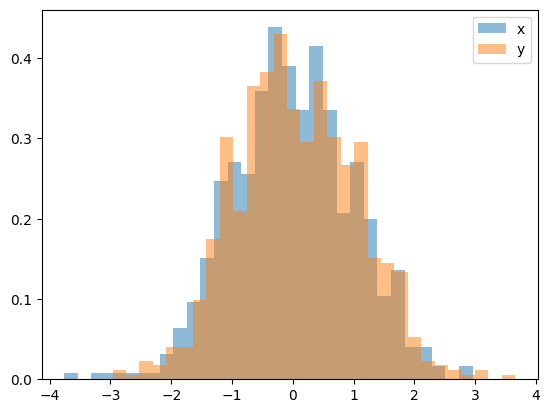

In [12]:
plt.hist(x_1, alpha=0.5, label='x', bins=30, density=True)
plt.hist(y_1, alpha=0.5, label='y', bins=30, density=True)
plt.legend(loc='upper right')
plt.show()

In [13]:
t_1 = RunsEqualityTest(x_1, y_1)
t_1.run_test()

H_0 = F_X = F_Y v.s F_X != F_Y
Rechazar H_0 si: Z <= -1.645
Valor que tomó la estadística R: R_obs = 640
Valor que tomó la estadística Z: Z_obs = -0.699
->No rechazamos H_0 con nivel de significancia 5.0%


In [14]:
x_2 = np.random.normal(loc=0, size=560)
y_2 = np.random.normal(loc=2, size=780)


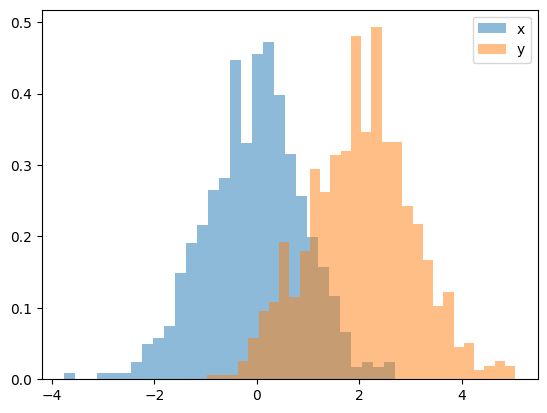

In [15]:
plt.hist(x_2, alpha=0.5, label='x', bins=30, density=True)
plt.hist(y_2, alpha=0.5, label='y', bins=30, density=True)
plt.legend(loc='upper right')
plt.show()

In [16]:
t_2 = RunsEqualityTest(x_2, y_2)
t_2.run_test()

H_0 = F_X = F_Y v.s F_X != F_Y
Rechazar H_0 si: Z <= -1.645
Valor que tomó la estadística R: R_obs = 262
Valor que tomó la estadística Z: Z_obs = -21.932
-> Rechazamos H_0 con nivel de significancia 5.0%


### Prueba de Mann-Whitney (U-test)

In [17]:
class MannWhitneyTest(EqualityTest):
    def __init__(self, x, y):
        """ Constructor de la clase.
        
        :param x: Mediciones de la primera distribución.
        :param y: Mediciones de la segunda distribución.
        """
        super().__init__(x, y)
        self.__u: int = 0
        self.__u_prime: int = 0
        self.__compute_u()
        self.__compute_u_prime()
        
    def get_u(self):
        """ Regresa el valor que toma la estadística U. """
        return self.__u
    
    def get_u_prime(self):
        """ Regresa el valor que toma la estadística U'. """
        return self.__u_prime
    
    def __compute_u(self):
        """ Calcula eficientemente el valor de la estadística U. """
        x_indices = self._indices["X"]
        u = sum(x_indices) - (self._n_1 * (self._n_1 - 1) / 2)
        self.__u = int(u)
        
    def __compute_u_prime(self):
        """ Calcula eficientemente el valor de la estadística U'. """
        # Aquí va tu código
    
    def __pmf(self, u):
        """ Función de masa de probabilidad de U (exacta). 
        
        :param u: El valor que toma U.
        """
        # Aquí va tu código
    
    def __test_statistic_asymptotic(self, u):
        """ Calcula la estadística de prueba asintótica.
        
        :param u: El valor que toma U o U'.
        :return: El valor que toma la estadística de pruba.
        """
        z = u + 0.5 - (self._n_1 * self._n_2 / 2)
        z /= np.sqrt((self._n_1 * self._n_2) * (self._n + 1 / 12))
        return z
    
    def run_test(self, alternative, alpha=0.05, exact=False):
        """ Realiza la prueba de hipótesis. 
        
        :param alternative: Hipótesis alternativa.
        :param alpha: Nivel de significancia deseado.
        :param exact: Si la prueba será exacta o asintótica.
        """
        if exact:
            pass
        else:
            if alternative == "F_X != F_Y" or alternative == "F_Y != F_X":
                z = self.__test_statistic_asymptotic(self.__u)
                z_prime = self.__test_statistic_asymptotic(self.__u_prime)
                c_alpha = norm.ppf(q=alpha/2)
                # Aquí va tu código
                
            elif alternative == "F_X < F_Y" or alternative == "F_Y > F_X":
                z_prime = self.__test_statistic_asymptotic(self.__u_prime)
                c_alpha = norm.ppf(q=alpha)
                # Aquí va tu código
                
            elif alternative == "F_X > F_Y" or alternative == "F_Y < F_X":
                z = self.__test_statistic_asymptotic(self.__u)
                c_alpha = norm.ppf(q=alpha)
                print("H_0 = F_X = F_Y v.s F_X > F_Y")
                print(f"Rechazar H_0: F_X = F_Y si: Z <= {c_alpha:.3f}")
                print(f"Valor que tomó la estadística U: U_obs = {self.__u}")
                print(f"Valor que tomó la estadística Z: Z_obs = {z:.3f}")
                decision = "-> Rechazamos H_0" if z <= c_alpha else "->No rechazamos H_0"
                print(decision + f" con nivel de significancia {alpha*100}%")

###### Verificamos que funcione

In [18]:
x = np.array([1, 6, 7])
y = np.array([2, 4, 9, 10, 12])

mw = MannWhitneyTest(x,y)

In [19]:
mw.get_sample()

array(['X', 'Y', 'Y', 'X', 'X', 'Y', 'Y', 'Y'], dtype='<U1')

In [20]:
mw.get_indices()

{'X': [0, 3, 4], 'Y': [1, 2, 5, 6, 7]}

In [21]:
mw.get_n_1(), mw.get_n_2()

(3, 5)

In [22]:
mw.get_u()

4

In [23]:
mw.run_test(alternative="F_Y < F_X")

H_0 = F_X = F_Y v.s F_X > F_Y
Rechazar H_0: F_X = F_Y si: Z <= -1.645
Valor que tomó la estadística U: U_obs = 4
Valor que tomó la estadística Z: Z_obs = -0.272
->No rechazamos H_0 con nivel de significancia 5.0%


###### Con más datos

In [24]:
x_3 = chi2.rvs(df=3, size=263)
y_3 = chi2.rvs(df=3, size=257)

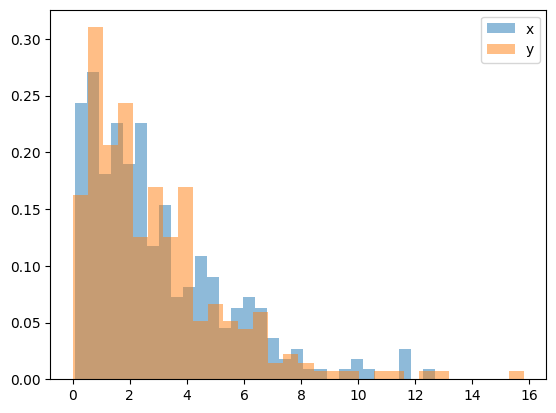

In [25]:
plt.hist(x_3, alpha=0.5, label='x', bins=30, density=True)
plt.hist(y_3, alpha=0.5, label='y', bins=30, density=True)
plt.legend(loc='upper right')
plt.show()

In [26]:
mw_3 = MannWhitneyTest(x_3, y_3)

In [27]:
mw_3.run_test(alternative="F_Y < F_X")

H_0 = F_X = F_Y v.s F_X > F_Y
Rechazar H_0: F_X = F_Y si: Z <= -1.645
Valor que tomó la estadística U: U_obs = 34433
Valor que tomó la estadística Z: Z_obs = 0.108
->No rechazamos H_0 con nivel de significancia 5.0%


In [28]:
x_4 = chi2.rvs(df=3, size=263)
y_4 = chi2.rvs(df=5, size=257)

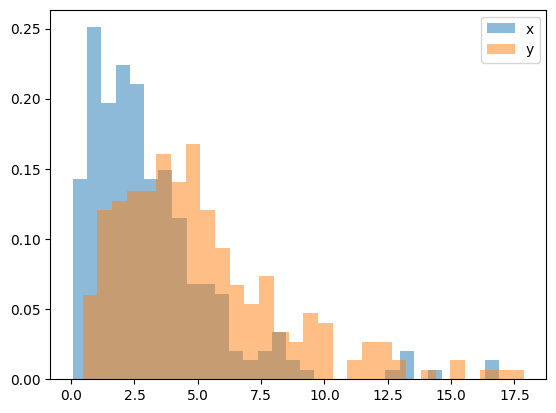

In [29]:
plt.hist(x_4, alpha=0.5, label='x', bins=30, density=True)
plt.hist(y_4, alpha=0.5, label='y', bins=30, density=True)
plt.legend(loc='upper right')
plt.show()

In [30]:
mw_4 = MannWhitneyTest(x_4, y_4)
mw_4.run_test(alternative="F_Y < F_X")

H_0 = F_X = F_Y v.s F_X > F_Y
Rechazar H_0: F_X = F_Y si: Z <= -1.645
Valor que tomó la estadística U: U_obs = 19749
Valor que tomó la estadística Z: Z_obs = -2.369
-> Rechazamos H_0 con nivel de significancia 5.0%


### Prueba suma de rangos de Wilcoxon

In [31]:
class WilcoxonTest:
    pass

#### Ejercicio 1.

El archivo data.csv contiene $613787$ registros con datos sobre sismos alrededor del mundo entre el año 2000 y el año 2023; en particular, se tiene el registro de la magnitud de todos los sismos.

Separe el total de registros en dos conjuntos de datos ($\mathcal{D}_X$ y $\mathcal{D}_Y$), de tal maneta que el primer conjunto de datos tenga las magnitudes de los sismos ocurridos desde el año 2000 hasta el año 2011, y el segundo conjunto contenga las magnitudes de los sismos ocurridos después de 2011 y hasta el 2023.

Claramente la magnitud de un sismo es una variable continua (aunque no se pueden medir con precisión infinita). Verifique que los demás supuestos se cumplen (de manera aproximada), a saber, simetría de las densidades, misma dispersión y tendencia central.

Luego, efectúe una prueba estadística con significancia del $10\%$ para verificar si ambos conjuntos de datos vienen o no de la misma distribución.

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [33]:
data = pd.read_csv("data.csv")
